In [5]:
#!/usr/bin/python
# -*- coding: utf8 -*-
"""
lof
~~~~~~~~~~~~
This module implements the Local Outlier Factor algorithm.
:copyright: (c) 2013 by Damjan Kužnar.
:license: GNU GPL v2, see LICENSE for more details.
"""
from __future__ import division
import warnings

def distance_euclidean(instance1, instance2):
    """Computes the distance between two instances. Instances should be tuples of equal length.
    Returns: Euclidean distance
    Signature: ((attr_1_1, attr_1_2, ...), (attr_2_1, attr_2_2, ...)) -> float"""
    def detect_value_type(attribute):
        """Detects the value type (number or non-number).
        Returns: (value type, value casted as detected type)
        Signature: value -> (str or float type, str or float value)"""
        from numbers import Number
        attribute_type = None
        if isinstance(attribute, Number):
            attribute_type = float
            attribute = float(attribute)
        else:
            attribute_type = str
            attribute = str(attribute)
        return attribute_type, attribute
    # check if instances are of same length
    if len(instance1) != len(instance2):
        raise AttributeError("Instances have different number of arguments.")
    # init differences vector
    differences = [0] * len(instance1)
    # compute difference for each attribute and store it to differences vector
    for i, (attr1, attr2) in enumerate(zip(instance1, instance2)):
        type1, attr1 = detect_value_type(attr1)
        type2, attr2 = detect_value_type(attr2)
        # raise error is attributes are not of same data type.
        if type1 != type2:
            raise AttributeError("Instances have different data types.")
        if type1 is float:
            # compute difference for float
            differences[i] = attr1 - attr2
        else:
            # compute difference for string
            if attr1 == attr2:
                differences[i] = 0
            else:
                differences[i] = 1
    # compute RMSE (root mean squared error)
    rmse = (sum(map(lambda x: x**2, differences)) / len(differences))**0.5
    return rmse

class LOF:
    """Helper class for performing LOF computations and instances normalization."""
    def __init__(self, instances, normalize=True, distance_function=distance_euclidean):
        self.instances = instances
        self.normalize = normalize
        self.distance_function = distance_function
        if normalize:
            self.normalize_instances()

    def compute_instance_attribute_bounds(self):
        min_values = [float("inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * n.inf
        max_values = [float("-inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * -1 * n.inf
        for instance in self.instances:
            min_values = tuple(map(lambda x,y: min(x,y), min_values,instance)) #n.minimum(min_values, instance)
            max_values = tuple(map(lambda x,y: max(x,y), max_values,instance)) #n.maximum(max_values, instance)

        diff = [dim_max - dim_min for dim_max, dim_min in zip(max_values, min_values)]
        if not all(diff):
            problematic_dimensions = ", ".join(str(i+1) for i, v in enumerate(diff) if v == 0)
            warnings.warn("No data variation in dimensions: %s. You should check your data or disable normalization." % problematic_dimensions)

        self.max_attribute_values = max_values
        self.min_attribute_values = min_values

    def normalize_instances(self):
        """Normalizes the instances and stores the infromation for rescaling new instances."""
        if not hasattr(self, "max_attribute_values"):
            self.compute_instance_attribute_bounds()
        new_instances = []
        for instance in self.instances:
            new_instances.append(self.normalize_instance(instance)) # (instance - min_values) / (max_values - min_values)
        self.instances = new_instances

    def normalize_instance(self, instance):
        return tuple(map(lambda value,max,min: (value-min)/(max-min) if max-min > 0 else 0,
                         instance, self.max_attribute_values, self.min_attribute_values))

    def local_outlier_factor(self, min_pts, instance):
        """The (local) outlier factor of instance captures the degree to which we call instance an outlier.
        min_pts is a parameter that is specifying a minimum number of instances to consider for computing LOF value.
        Returns: local outlier factor
        Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
        if self.normalize:
            instance = self.normalize_instance(instance)
        return local_outlier_factor(min_pts, instance, self.instances, distance_function=self.distance_function)

def k_distance(k, instance, instances, distance_function=distance_euclidean):
    #TODO: implement caching
    """Computes the k-distance of instance as defined in paper. It also gatheres the set of k-distance neighbours.
    Returns: (k-distance, k-distance neighbours)
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> (float, ((attr_j_1, ...),(attr_k_1, ...), ...))"""
    distances = {}
    for instance2 in instances:
        distance_value = distance_function(instance, instance2)
        if distance_value in distances:
            distances[distance_value].append(instance2)
        else:
            distances[distance_value] = [instance2]
    distances = sorted(distances.items())
    neighbours = []
    [neighbours.extend(n[1]) for n in distances[:k]]
    k_distance_value = distances[k - 1][0] if len(distances) >= k else distances[-1][0]
    return k_distance_value, neighbours

def reachability_distance(k, instance1, instance2, instances, distance_function=distance_euclidean):
    """The reachability distance of instance1 with respect to instance2.
    Returns: reachability distance
    Signature: (int, (attr_1_1, ...),(attr_2_1, ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(k, instance2, instances, distance_function=distance_function)
    return max([k_distance_value, distance_function(instance1, instance2)])

def local_reachability_density(min_pts, instance, instances, **kwargs):
    """Local reachability density of instance is the inverse of the average reachability
    distance based on the min_pts-nearest neighbors of instance.
    Returns: local reachability density
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    reachability_distances_array = [0]*len(neighbours) #n.zeros(len(neighbours))
    for i, neighbour in enumerate(neighbours):
        reachability_distances_array[i] = reachability_distance(min_pts, instance, neighbour, instances, **kwargs)
    if not any(reachability_distances_array):
        warnings.warn("Instance %s (could be normalized) is identical to all the neighbors. Setting local reachability density to inf." % repr(instance))
        return float("inf")
    else:
        return len(neighbours) / sum(reachability_distances_array)

def local_outlier_factor(min_pts, instance, instances, **kwargs):
    """The (local) outlier factor of instance captures the degree to which we call instance an outlier.
    min_pts is a parameter that is specifying a minimum number of instances to consider for computing LOF value.
    Returns: local outlier factor
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    instance_lrd = local_reachability_density(min_pts, instance, instances, **kwargs)
    lrd_ratios_array = [0]* len(neighbours)
    for i, neighbour in enumerate(neighbours):
        instances_without_instance = set(instances)
        instances_without_instance.discard(neighbour)
        neighbour_lrd = local_reachability_density(min_pts, neighbour, instances_without_instance, **kwargs)
        lrd_ratios_array[i] = neighbour_lrd / instance_lrd
    return sum(lrd_ratios_array) / len(neighbours)

def outliers(k, instances, **kwargs):
    """Simple procedure to identify outliers in the dataset."""
    instances_value_backup = instances
    outliers = []
    for i, instance in enumerate(instances_value_backup):
        instances = list(instances_value_backup)
        instances.remove(instance)
        l = LOF(instances, **kwargs)
        value = l.local_outlier_factor(k, instance)
        if value > 1:
            outliers.append({"lof": value, "instance": instance, "index": i})
    outliers.sort(key=lambda o: o["lof"], reverse=True)
    return outliers
    

In [2]:
instances = [
 (10,0.0),
(9,0.1),
(10,0.2),
(9,0.3),
(8,0.4),
(7,0.5),
(8,0.6),
(9,0.7),
(10,0.8),
(10,0.9),
(0,1.0),#1
(1,1.1),#2
(10,1.2),
(9,1.3),
(10,1.4),
(8,1.5),
(7,1.6),
(8,1.7),
(5,1.8),
(5,1.9),
(5,2.0),
(5,2.1),
(5,2.2),
(5,2.3),
(4,2.4),
(4,2.5),
(4,2.6),
(4,2.7),
(4,2.8),
(3,2.9),
(3,3.0),
(3,3.1),
(10,3.2),#3
(3,3.3),
(3,3.4),
(2,3.5),
(2,3.6),
(1,3.7),
(1,3.8),
(0,3.9),
(0,4.0),
(0,4.1),
(0,4.2),
(0,4.3),
(10,4.4),#4
(0,4.5),
(3,4.6),
(3,4.7),
(3,4.8),
(4,4.9),
(4,5.0),
(4,5.1),
(5,5.2),
(5,5.3),
(5,5.4),
(6,5.5),
(6,5.6),
(6,5.7),
(7,5.8),
(7,5.9),
(7,6.0),
(8,6.1),
(8,6.2),
(8,6.3),
(9,6.4),
(9,6.5),
(9,6.6),
(10,6.7),
(10,6.8),
(10,6.9),
(9,7.0),
(8,7.1),
(9,7.2),
(10,7.3),
(9,7.4),
(8,7.5),
(9,7.6),
(8,7.7),
(7,7.8),
(7,7.9),
(7,8.0),
(7,8.1),
(0,8.2),#5
(7,8.3),
(7,8.4),
(7,8.5),
(6,8.6),
(6,8.7),
(6,8.8),
(7,8.9),
(7,9.0),
(7,9.1),
(8,9.2),
(8,9.3),
(8,9.4),
(9,9.5),
(9,9.6),
(10,9.7),
(10,9.8),
(10,9.9)
 ]

In [3]:
instances=[
  (9.62962962962963,0.1),
(9.62962962962963,0.2),
(8.88888888888889,0.3),
(6.666666666666667,0.4),
(0.0,0.5),
(6.666666666666667,0.6),
(9.166666666666666,0.7),
(8.88888888888889,0.8),
(9.62962962962963,0.9),
(9.62962962962963,1.0)
]

In [6]:
lof = outliers(6, instances)

for outlier in lof:
    print (outlier["lof"],outlier["instance"])

3.304621980168657 (0.0, 0.5)
1.0179831938933634 (9.62962962962963, 0.1)


[(9.62962962962963, 0.1), (9.62962962962963, 0.2), (8.88888888888889, 0.3), (6.666666666666667, 0.4), (0.0, 0.5), (6.666666666666667, 0.6), (9.166666666666666, 0.7), (8.88888888888889, 0.8), (9.62962962962963, 0.9), (9.62962962962963, 1.0)]


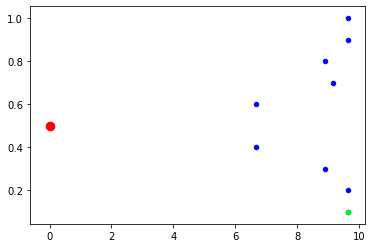

In [7]:
from matplotlib import pyplot as p

x,y = zip(*instances)
p.scatter(x,y, 20, color="#0000FF")

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1.5 else "#00FF00"
    p.scatter(instance[0], instance[1], color=color, s=(value-1)**2*10+20)

print(instances)
p.show()